In [1]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import random
import json
import math

import numpy as np
import pandas as pd
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sn


from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils_seedly import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### Configuration for training
Configuration for such as: director for data, log and outputs


In [2]:
args = {
    'data_dir': 'data_seedly/',
    'model_type':  'bert',
    'model_name': 'bert-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs_seedly_logged_BERT_report/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 64,
    'eval_batch_size': 64,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 100,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': False,
    'notes': 'Using Yelp Reviews dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
### Uncomment this if you want to train for the first time
# if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
#     raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [4]:
config_class, model_class, tokenizer_class = (BertConfig, BertForSequenceClassification, BertTokenizer)

### Load tokenizer for BERT 

In [5]:
config = config_class.from_pretrained(args['model_name'], num_labels=5, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/chungsoo002/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.

### Load pretrained BERT model
Also specify the specific details of the architecture: such as number of classes

In [6]:
### Uncomment this if you want to train for the first time
# model = model_class.from_pretrained(args['model_name'], num_labels=5, hidden_dropout_prob=0.3)
# model.to(device);

### DataLoader
Here we define functions to efficiently load data and then feed into the neural network.

In [7]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    label_list = processor.get_labels()
    num_labels = len(label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

In [8]:
from torch.utils.data import Dataset, DataLoader

class yelpDataset(Dataset):
  def __init__(self, examples, label_list, args, tokenizer, output_mode):
    self.examples=examples
    self.label_list = label_list
    self.args = args
    self.tokenizer = tokenizer
    self.output_mode = output_mode
      
  def __len__(self):
    # return size of dataset
    return len(self.examples)
      
  def __getitem__(self, idx):
    features = convert_examples_to_features(self.examples[idx], self.label_list, self.args['max_seq_length'], self.tokenizer, self.output_mode,
                cls_token_at_end=bool(self.args['model_type'] in ['xlnet']),            
                cls_token=self.tokenizer.cls_token,
                cls_token_segment_id=2 if self.args['model_type'] in ['xlnet'] else 0,
                sep_token=self.tokenizer.sep_token,
                sep_token_extra=bool(self.args['model_type'] in ['roberta']),           
                pad_on_left=bool(self.args['model_type'] in ['xlnet']),                 
                pad_token=self.tokenizer.convert_tokens_to_ids([self.tokenizer.pad_token])[0],
                pad_token_segment_id=4 if self.args['model_type'] in ['xlnet'] else 0)
    
    all_input_ids = torch.tensor(features.input_ids, dtype=torch.long)
    all_input_mask = torch.tensor(features.input_mask, dtype=torch.long)
    all_segment_ids = torch.tensor(features.segment_ids, dtype=torch.long)
    if self.output_mode == "classification":
        all_label_ids = torch.tensor(features.label_id, dtype=torch.long)
    elif self.output_mode == "regression":
        all_label_ids = torch.tensor(features.label_id, dtype=torch.float)

    dataset = (all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [9]:
def load_and_cache_examples(task, tokenizer, mode):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    
    label_list = processor.get_labels()
    if mode == 'train':
        examples = processor.get_train_examples(args['data_dir'])
    elif mode == 'eval':
        examples = processor.get_dev_examples(args['data_dir'])
    elif mode == 'test':
        examples = processor.get_test_examples(args['data_dir'])
    
        
    if __name__ == "__main__":
        dataset=yelpDataset(examples, label_list, args, tokenizer, output_mode)
    return dataset

### Define functions to compute evaluation metrics 

In [10]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    cf = confusion_matrix(labels, preds, labels=[0,1,2,3,4])
    return {
        "mcc": mcc,
        "cf": cf
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)


### Train, Eval, Test function 

In [11]:
### Uncomment this if you want to train for the first time
# def train(dataset, model, tokenizer):
#     EVAL_TASK = args['task_name']
#     tb_writer = SummaryWriter('./log_seedly_train_BERT_report_lowdim')
#     train_dataset, eval_dataset, test_dataset = dataset
    
#     train_sampler = RandomSampler(train_dataset)
#     train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
#     eval_sampler = SequentialSampler(eval_dataset)
#     eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])
#     test_sampler = SequentialSampler(test_dataset)
#     test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=args['eval_batch_size'])
    
#     t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
#     no_decay = ['bias', 'LayerNorm.weight']
#     optimizer_grouped_parameters = [
#         {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
#         {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
#         ]
    
#     warmup_steps = math.ceil(t_total * args['warmup_ratio'])
#     args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']
    
#     optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
#     scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
#     if args['fp16']:
#         try:
#             from apex import amp
#         except ImportError:
#             raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
#         model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
#     logger.info("***** Running training *****")
#     logger.info("  Num examples = %d", len(train_dataset))
#     logger.info("  Num Epochs = %d", args['num_train_epochs'])
#     logger.info("  Total train batch size  = %d", args['train_batch_size'])
#     logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
#     logger.info("  Total optimization steps = %d", t_total)

#     global_step = 0
    
#     model.zero_grad()
#     train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
#     epoch = 0
#     for _ in train_iterator:
#         epoch += 1
#         epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
#         tr_loss, logging_loss = 0.0, 0.0
#         tr_acc, log_acc = 0.0, 0.0
#         nb_train_steps = 0
#         for step, batch in enumerate(epoch_iterator):
#             model.train()
#             batch = tuple(t.to(device) for t in batch)
#             inputs = {'input_ids':      batch[0],
#                       'attention_mask': batch[1],
#                       'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
#                       'labels':         batch[3]}
#             outputs = model(**inputs)
#             loss, logits = outputs[0:2]  # model outputs are always tuple in pytorch-transformers (see doc)
#             print("\r%f" % loss, end='')
#             nb_train_steps += 1
#             preds = logits.detach().cpu().numpy()
#             out_label_ids = inputs['labels'].detach().cpu().numpy()

#             if args['output_mode'] == "classification":
#                 preds = np.argmax(preds, axis=1)
#             elif args['output_mode'] == "regression":
#                 preds = np.squeeze(preds)
#             result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
#             c = result['cf']
#             acc=(c[0,0] + c[1,1] + c[2,2] + c[3,3] + c[4,4])/np.sum(np.sum(c))


#             if args['gradient_accumulation_steps'] > 1:
#                 loss = loss / args['gradient_accumulation_steps']

#             if args['fp16']:
#                 with amp.scale_loss(loss, optimizer) as scaled_loss:
#                     scaled_loss.backward()
#                 torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])

#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

#             tr_loss += loss.item()
#             tr_acc = (tr_acc * (nb_train_steps-1) + acc)/(nb_train_steps) 
#             if (step + 1) % args['gradient_accumulation_steps'] == 0:
#                 optimizer.step()
#                 scheduler.step()  # Update learning rate schedule
#                 model.zero_grad()
#                 global_step += 1

# #                 if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
# #                     # Log metrics
# #                     if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
# #                         results, _ = evaluate(model, tokenizer)
# #                         for key, value in results.items():
# #                             tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
# #                     tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
# #                     tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
# #                     logging_loss = tr_loss

#                 if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
#                     # Save model checkpoint
#                     output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
#                     if not os.path.exists(output_dir):
#                         os.makedirs(output_dir)
#                     model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
#                     model_to_save.save_pretrained(output_dir)
#                     logger.info("Saving model checkpoint to %s", output_dir)
#         tr_loss = tr_loss/nb_train_steps
#         # Eval!
#         prefix = global_step
#         logger.info("***** Running evaluation {} *****".format(prefix))
#         logger.info("  Num examples = %d", len(eval_dataset))
#         logger.info("  Batch size = %d", args['eval_batch_size'])
#         eval_loss = 0.0
#         nb_eval_steps = 0
#         preds = None
#         out_label_ids = None
#         for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
#             model.eval()
#             batch = tuple(t.to(device) for t in batch)

#             with torch.no_grad():
#                 inputs = {'input_ids':      batch[0],
#                           'attention_mask': batch[1],
#                           'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
#                           'labels':         batch[3]}
#                 outputs = model(**inputs)
#                 tmp_eval_loss, logits = outputs[:2]

#                 eval_loss += tmp_eval_loss.mean().item()
#             nb_eval_steps += 1
#             if preds is None:
#                 preds = logits.detach().cpu().numpy()
#                 out_label_ids = inputs['labels'].detach().cpu().numpy()
#             else:
#                 preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
#                 out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

#         eval_loss = eval_loss / nb_eval_steps
#         if args['output_mode'] == "classification":
#             preds = np.argmax(preds, axis=1)
#         elif args['output_mode'] == "regression":
#             preds = np.squeeze(preds)
#         result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
#         c = result['cf']
#         eval_acc=(c[0,0] + c[1,1] + c[2,2] + c[3,3] + c[4,4])/np.sum(np.sum(c))
        
#         # Test!
#         logger.info("***** Running test {} *****".format(prefix))
#         logger.info("  Num examples = %d", len(test_dataset))
#         logger.info("  Batch size = %d", args['eval_batch_size'])
#         test_loss = 0.0
#         nb_test_steps = 0
#         preds = None
#         out_label_ids = None
#         for batch in tqdm_notebook(test_dataloader, desc="Testing"):
#             model.eval()
#             batch = tuple(t.to(device) for t in batch)

#             with torch.no_grad():
#                 inputs = {'input_ids':      batch[0],
#                           'attention_mask': batch[1],
#                           'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
#                           'labels':         batch[3]}
#                 outputs = model(**inputs)
#                 tmp_eval_loss, logits = outputs[:2]

#                 test_loss += tmp_eval_loss.mean().item()
#             nb_test_steps += 1
#             if preds is None:
#                 preds = logits.detach().cpu().numpy()
#                 out_label_ids = inputs['labels'].detach().cpu().numpy()
#             else:
#                 preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
#                 out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

#         test_loss = test_loss / nb_test_steps
#         if args['output_mode'] == "classification":
#             preds = np.argmax(preds, axis=1)
#         elif args['output_mode'] == "regression":
#             preds = np.squeeze(preds)
#         result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
#         c = result['cf']
#         test_acc=(c[0,0] + c[1,1] + c[2,2] + c[3,3] + c[4,4])/np.sum(np.sum(c))
        
#         # Log metrics
#         tb_writer.add_scalar('train_loss', tr_loss, epoch)
#         tb_writer.add_scalar('eval_loss', eval_loss, epoch)
#         tb_writer.add_scalar('test_loss', test_loss, epoch)
#         tb_writer.add_scalar('train_acc', tr_acc, epoch)
#         tb_writer.add_scalar('eval_acc', eval_acc, epoch)
#         tb_writer.add_scalar('test_acc', test_acc, epoch)

#     return global_step

In [12]:
### Uncomment this if you want to train for the first time
# if args['do_train']:
#     train_dataset = load_and_cache_examples(task, tokenizer, 'train')
#     eval_dataset = load_and_cache_examples(task, tokenizer, 'eval')
#     test_dataset = load_and_cache_examples(task, tokenizer, 'test')
#     dataset = [train_dataset, eval_dataset, test_dataset]
#     global_step= train(dataset, model, tokenizer)


### Save final checkpoint 

In [13]:
### Uncomment this if you want to train for the first time
# if args['do_train']:
#     if not os.path.exists(args['output_dir']):
#             os.makedirs(args['output_dir'])
#     logger.info("Saving model checkpoint to %s", args['output_dir'])
    
#     model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
#     model_to_save.save_pretrained(args['output_dir'])
#     tokenizer.save_pretrained(args['output_dir'])
#     torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))    

### Test the model 

In [16]:
def evaluate(model, tokenizer, prefix=""):
    EVAL_TASK = args['task_name']
    test_dataset = load_and_cache_examples(task, tokenizer, 'test')
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(test_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            _, logits = outputs[:2]

        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    confusion_matrix = result['cf']
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                      columns = [i for i in "12345"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap='gist_earth_r')
    acc=(confusion_matrix[0,0] + confusion_matrix[1,1] + confusion_matrix[2,2] + confusion_matrix[3,3] + confusion_matrix[4,4])/np.sum(np.sum(confusion_matrix))
    print("\nTest Accuracy of BERT model trained on seedly dataset: {:.4f}".format(acc))
    
    total_param = 0
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    print('\nTotal parameters:', total_param)

INFO:pytorch_transformers.modeling_utils:loading configuration file outputs_seedly_logged_BERT_report/checkpoint-2000/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file outputs_seedly_logged_BERT_report/checkpoint-2000/pytorch_model.bin




Test Accuracy of BERT model trained on seedly dataset: 0.6715

Total parameters: 108314117


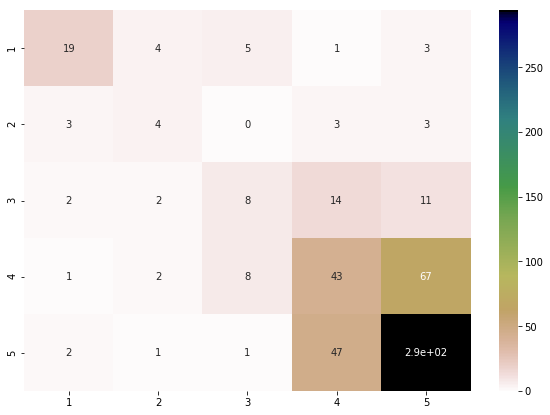

In [17]:
model = model_class.from_pretrained('outputs_seedly_logged_BERT_report/checkpoint-2000')
model.to(device);
evaluate(model, tokenizer)